In [1]:
import seaborn as sns
import numpy as np
import pylab as plt
import pandas as pd
from scipy import stats
import cv2
import time
import re
import math
from sklearn import mixture
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)

from sqlalchemy import *

from scipy.ndimage.interpolation import shift
from scipy.interpolate import interp1d
from scipy.optimize import newton

import heapq
import seaborn as sns
from sklearn import linear_model

import matplotlib.path as mplPath
import matplotlib.patches as patches



import matplotlib
plt.rcParams['figure.figsize'] = (20, 20)
%matplotlib inline
from IPython import display


In [2]:
class DataProcessor(object):

    def __init__(self,data_path,map_path):
        
        print "initialization will take some time"
        start_time = time.time()
        engine = create_engine('sqlite+pysqlite:///'+data_path)
        ADCdf = pd.io.sql.read_sql("SELECT * FROM ADC", engine)
        end_time = time.time()
        print end_time-start_time

        engine = create_engine('sqlite+pysqlite:///'+map_path)
        ProtoMapdf = pd.io.sql.read_sql("SELECT * FROM ProtoMap", engine)
        print ProtoMapdf.head()
        print "loading finished"
        
        print "begin processing"
        start_time = time.time()
        ADCdfn = ADCdf.copy()

        ADCdfn.columns = [np.uint16(_[1:]) if re.match('t\d+',_) is not None else str(_) for _ in ADCdfn.columns ]
        ADCdfn['max'] = ADCdfn.iloc[:,3+50:-50].max(axis=1)
        mask= (ADCdfn.iloc[:,3:-1]>20) & (ADCdfn.iloc[:,3:-1].gt(ADCdfn['max']*0.2,axis=0))
        ADCdfn.iloc[:,3:-1] = ADCdfn.iloc[:,3:-1][mask].fillna(0)
        end_time = time.time()
        print end_time-start_time
        
        start_time = time.time()
        n1 = [_ for _ in ADCdfn.columns if type(_) is np.uint16]
        n2 = [_ for _ in ADCdfn.columns if type(_) is not np.uint16]
        t2 = pd.melt(ADCdfn.iloc[:],id_vars=n2,value_vars=n1).drop(['ID'],axis=1)
        t2.columns = ['EventID','PadNum','max','time','charge']
        self.t3 = pd.merge(t2[t2['charge']>20],ProtoMapdf,on='PadNum')[['EventID','PadNum','time','PadX','PadY','charge']]
        print time.time() - start_time
        
        print "processing finished"
        
        self.ADCdfn = ADCdfn
        self.ADCdf = ADCdf
        self.ProtoMapdf = ProtoMapdf
        


In [3]:
dp = DataProcessor('../../data/SQL/10C/88_8.db','../../data/SQL/10C/ProtoMap.db')

initialization will take some time
140.028626919
   PadNum        PadName     PadX      PadY  BinNum
0       0  sector_center  0.00000  0.000000     257
1       1      sector1_0  1.30108  0.947523       1
2       2      sector2_0  2.18496  1.831410       2
3       3      sector1_1  2.71529  2.361740       3
4       4      sector2_1  3.59917  3.245620       4
loading finished
begin processing
15.1784751415
30.7858490944
processing finished


In [4]:
def ConstructImage(t3,EID):

    tmp = t3[(t3['EventID']==EID)&(t3['charge']>3)].copy()
    p = (tmp['PadNum']-1)%63+1

    tmp['PadPos'] = ((p-9)*(p>9)+p)*(tmp['PadNum']!=0)

    Q = [tmp[(tmp['PadX']>0)&(tmp['PadY']>0)] ,tmp[(tmp['PadX']<0)&(tmp['PadY']>0)],
        tmp[(tmp['PadX']<0)&(tmp['PadY']<0)], tmp[(tmp['PadX']>0)&(tmp['PadY']<0)]]


    image1 = np.zeros([300,600])

    image1[(-Q[0]['PadPos'].values+151).astype(np.int), Q[0]['time'].values.astype(np.int)] =255
    image1[(Q[2]['PadPos'].values+150).astype(np.int), Q[2]['time'].values.astype(np.int)] =255

    image2 = np.zeros([300,600])

    image2[(-Q[1]['PadPos'].values+151).astype(np.int), Q[1]['time'].values.astype(np.int)] =255
    image2[(Q[3]['PadPos'].values+150).astype(np.int), Q[3]['time'].values.astype(np.int)] =255


    width,height = 300,600
    a = np.concatenate([np.arange(width/2,0,-1),np.arange(1,width/2+1,1)])
    weights = np.tile(a,height).reshape(height,width).T/150.0

    image1[:50,:] = 0
    image2[:50,:] = 0

    image1[-50:,:] = 0
    image2[-50:,:] = 0

    

    if np.sum(image1*image2*weights**4)>np.sum(image1*image2[::-1]*weights**4):
        image = image1+image2#[::-1]
    else:
        image = image1+image2[::-1]

    
        
    image = np.where(image>100,255,0).astype(np.uint8)

    
    gray = cv2.GaussianBlur(image, (3, 3), 0)
    ret,im = cv2.threshold(gray.astype(np.uint8), 10, 255, cv2.THRESH_BINARY)
    thresh = im.astype(np.uint8)
    
    #return

    for _ in range(3):
        thresh = cv2.erode(thresh, None, iterations=1)
        thresh = cv2.dilate(thresh, None, iterations=1)
    return thresh    


In [15]:
def AveDist(x,y,k,b):
    return np.sum(np.abs(k*x+b-y)/(k*k+1))/x.shape[0]

def r2(x,y,k,b):
    return 1-np.sum(((x*k+b)-y)**2)/np.sum((y-np.mean(y))**2)

def VertexPos(fits,y0):
    fits = [f for f in fits if f[0]>60 and f[-1]<2.5]
    
    num_lines = len(fits)
    
    if num_lines == 0: raise Exception('This is probably an unreacted beam')
    fits = fits[:1]+[f for f in fits[1:] if abs(f[1]-fits[0][1])/(abs(fits[0][1])+1e-9)>0.5]
    k1,b1 = fits[0][1:3]
    
    num_lines = len(fits)
    
    if num_lines==1:
        return (y0-b1)/k1,y0
    else:
        k2,b2 = fits[1][1:3]
        return (b2-b1)/(k1-k2), (k2*b1-k1*b2)/(k2-k1)


    
def tbjcfit(xs,ys):
    xc,yc = xs.mean(),ys.mean()
    u,s,v = np.linalg.svd(np.array([xs-xc,ys-yc]).T)
    xi,yi = v[0]
    k = yi/(xi+1e-9*abs(xi)/xi)
    b = yc-k*xc
    return k,b
    
    
        
def GetFit(image_, part_thresh=60, err_thresh =1.2,spread_thresh=6):        

    if np.sum(image_>10) > part_thresh:
        ys,xs = np.where(image_)
        
        try:

            k,b = tbjcfit(xs,ys)

            if AveDist(xs,ys,k,b)<err_thresh and (np.std(xs)>spread_thresh or np.std(ys)>spread_thresh):

                return (np.sum(image_>10),k,b,AveDist(xs,ys,k,b))
            else:
                return (0,0,0,100)
        except:
            return (0,0,0,100)

    else:
        return (0,0,0,100)
    
def FilterBackground(image):
    hull = convexHull(image, debug_mode = False)

    ys,xs = np.where(image)
    path1 = mplPath.Path(hull[:,0,:])
    patch = patches.PathPatch(path1, facecolor=(0,0,0,0),EdgeColor='r', lw=2)
    mask = path1.contains_points(zip(xs,ys))
    image_ = np.zeros(image.shape,dtype=np.uint8)
    image_[ys[mask],xs[mask]] = 255
    
    return image_
    
        
def GetRange(pic,debug_mode=0, center_width = 12, quadrant_thresh=100, center_thresh=300, 
             err_thresh =12, spread_thresh=6 ):
    pic_ = np.copy(pic)

    points = TipFinder(pic_,debug_mode)
    xv,yv = points[points[:,0].argsort()][-1]
    return
    #### get fit from each of the quadrant ###
    fits = []
    for idx in range(2):
        image_ = np.copy(pic_)
        if idx:
            image_[int(yv)-center_width:,:] = 0
        else:
            image_[:int(yv)+center_width,:] = 0
        
        fits.append(GetFit(cv2.erode(image_, None, iterations=1),
                    quadrant_thresh,err_thresh,spread_thresh))

    ##### get the fitting from the center line ####
    fit = fits[0] if fits[0][0]>quadrant_thresh and fits[0][-1]<err_thresh else fits[1]
    if fit[0]>quadrant_thresh and fit[-1]<err_thresh:
        y_,x_ = (150-fit[2])/fit[1],150
        image_ = np.copy(pic_)
        image_[:,:int(y_)+10] = 0  
        fits.append(GetFit(cv2.erode(image_, None, iterations=1),
                           center_thresh,err_thresh,spread_thresh))

    else:
        fits.append((0,0,0,100))
    
    
    ### process the fits according to each of the scenario
    xc,yc = VertexPos(fits,yv)
    
    if debug_mode:
        for s_,k_,b_,err_ in fits: 
            if s_>60 and err_<3: plt.plot(np.linspace(0,600,2),b_+k_*np.linspace(0,600,2))
        plt.scatter([xc],[yc],marker='o',s=300,c='g')
    
    return ((xc-xv)**2+(yc-yv)**2)**0.5


def Distance(contours,n1,n2):

    c1,c2 = contours[n1], contours[n2]

    c1,c2 = c1[:,0,:],c2[:,0,:]

    m1 = np.repeat([c1],c2.shape[0],axis=0)
    m2 = np.repeat([c2],c1.shape[0],axis=0)
    t2 = np.transpose(m2,axes=(1,0,2))
    diff = np.sqrt(np.sum(np.power(m1-t2,2),axis=2))

    return np.min(diff)

def Groups(contours):
    r,a = [],[]
    ## breadth first search
    pool = range(len(contours))
    area = 0
    while pool:
        seen = set([pool[0]])
        ans = set([pool[0]])
        sea = set([pool[0]])
        area = cv2.contourArea(contours[pool[0]])


        while sea:
            nsea = set([])

            for c in sea:
                for n in pool:
                    if n not in seen and Distance(contours,c,n)<40:
                        #print Distance(c,n),Distance(c,n)<8
                        area += cv2.contourArea(contours[n])
                        ans.add(n)
                        nsea.add(n)
                        seen.add(n)
            sea = nsea

        pool = [_ for _ in pool if _ not in ans]


        #print pool
        a.append(area)
        r.append(ans)

    r = [[contours[__] for __ in _] for _ in r]

    return zip(*[(x,y) for x,y in zip(r,a) if y>500])


def convexHull(thresh, debug_mode = 0):

    thresh = np.copy(thresh)
    if debug_mode: sns.heatmap(thresh[::-1], xticklabels=30, yticklabels=30)

    m1, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    
    gpc,gpa = Groups(contours)
    gpc = [np.concatenate(g,axis=0) for g in gpc]
    
    if debug_mode: plt.scatter(gpc[0][:,0,0],gpc[0][:,0,1])
    
    cnt = gpc[np.argmax(gpa)]
    hull = cv2.convexHull(cnt)
    
    if debug_mode: plt.plot(hull[:,0,0],hull[:,0,1],c='r')
    
    return hull#[:,0,:]


def MaxEnclosedTriangle(hull):
    def area(*i):
        a,b,c= hull[i,0]
        return np.abs(np.cross(b-c,c-a))

    A = 0;B = 1; C = 2; n=hull.shape[0]
    bA= A; bB= B; bC= C #The "best" triple of points
    while True: #loop A
        while True: #loop B
            while area(A, B, C) <= area(A, B, (C+1)%n): #loop C
                C = (C+1)%n
            if area(A, B, C) <= area(A, (B+1)%n, C): 
                B = (B+1)%n
                continue
            else:
                break

        if area(A, B, C) > area(bA, bB, bC):
            bA = A; bB = B; bC = C

        A = (A+1)%n
        if A==B: B = (B+1)%n
        if B==C: C = (C+1)%n
        if A==0: break
    
    return bA,bB,bC
    
def TipFinder(thresh, debug_mode = 0):

    hull = convexHull(thresh, debug_mode)
        
    #############################
    bA,bB,bC = MaxEnclosedTriangle(hull)

    if debug_mode: plt.scatter(hull[[bA,bB,bC],0,0],hull[[bA,bB,bC],0,1],marker='*', s=500,c='g')
    
    return hull[[bA,bB,bC],0]
    


for EID in sorted(dp.t3['EventID'].unique()):
    plt.clf()
    try:
        image = dp.ConstructImage(EID)
        GetRange(image,1)
    except:
        pass
    plt.savefig('{:04}.png'.format(EID))

In [12]:
cv2.setNumThreads(1)

In [18]:
dist = []
for i in  sorted(dp.t3['EventID'].unique())[:300]:
    
    try:
        print i
        image = ConstructImage(dp.t3,i)
        image = FilterBackground(image)
        GetRange(image.astype(np.uint8),0)
    except:
        pass


1
2
3
4
5
7
9
10
11
12
13
14
15
17
18
22
25
26
27
28
29
30
31
32
33
34
35
36
38
39
40
41
42
43
44
45
46
47
48
50
51
56
57
58
62
63
64
65
67
68
70
71
73
74
77
79
82
83
85
88
89
90
91
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
116
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
216
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
246
247
248
249
250
251
252
254
255
257
258
259
260
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
295
296
297
299
300
301
302
304
305
306
307
308
309
310
312
313
314


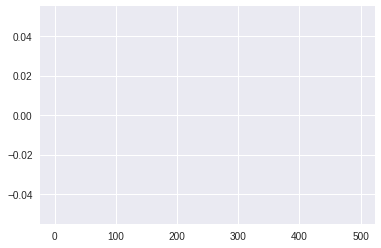

In [7]:
plt.hist(dist,bins=np.arange(0,500,2));